# functiong說明

save_and_open_excel 存成EXCEL 然後 打開
>save_and_open_excel(dataframe, file_name="模型相關數值.xlsx")

analyze_nan_and_zero_values 檢視空值
>analyze_nan_and_zero_values(data, threshold, sort_column="零值+NAN佔比 (%)", ascending=False)

output_coefficients 輸出模型係數
>output_coefficients(model, poly_features, feature_names)

plot_confusion_matrix 繪製混淆矩陣的熱力圖
>plot_confusion_matrix(y_test, y_pred_lr)

In [16]:
def save_and_open_excel(dataframe, file_name="模型相關數值.xlsx"):
    """
    將給定的 dataframe 保存到指定的 Excel 工作表中，如果工作表已存在則覆蓋，
    並嘗試在支持的應用程式中打開該 Excel 文件。

    :param dataframe: 要保存的 pandas DataFrame。
    :param file_name: Excel 文件的名稱，默認為 'vif_data.xlsx'。
    """
    import pandas as pd
    import os

    # 獲取 dataframe 的變數名稱
    frame_name = [name for name, var in globals().items() if var is dataframe][0]

    # 檢查工作表是否存在，如果不存在則創建
    if not os.path.isfile(file_name):
        with pd.ExcelWriter(file_name, engine="openpyxl") as writer:
            dataframe.to_excel(writer, sheet_name=frame_name, index=False)
    else:
        # 工作表存在，加載工作簿
        with pd.ExcelWriter(
            file_name, engine="openpyxl", mode="a", if_sheet_exists="replace"
        ) as writer:
            dataframe.to_excel(writer, sheet_name=frame_name, index=False)

    # 嘗試打開創建的 Excel 文件
    try:
        os.startfile(file_name)
    except AttributeError:
        # 如果 os.startfile() 不可用（例如在非 Windows 系統上），使用適當的替代方案
        if os.name == "posix":
            os.system(f'open "{file_name}"')
        else:
            os.system(f'start "{file_name}"')
    except Exception as e:
        print(f"打開 Excel 文件時發生錯誤: {e}")

In [15]:
"""檢視空值及零值"""

import pandas as pd


def analyze_nan_and_zero_values(
    data, threshold, sort_column="零值+NAN佔比 (%)", ascending=False
):
    """
    檢查0值和 nan 的數量
    threshold 為 百分比，例threshold=20，會回傳 零值+NAN佔比 (%) 大於20% 的
    當 threshold = 0 會回傳全部
    """

    # 如果輸入是文件路徑，讀取CSV文件並轉換成Pandas DataFrame

    if isinstance(data, str):

        file_source_pd = pd.read_csv(data)

    # 如果輸入是Pandas DataFrame，直接使用它

    elif isinstance(data, pd.DataFrame):

        file_source_pd = data

    else:

        raise ValueError(
            "Invalid input type. Input must be either file path or Pandas DataFrame."
        )

    # 計算這個範圍內每一欄的空白值(NaN)數量

    nan_values_per_column_in_range = file_source_pd.isnull().sum(axis=0)

    # 計算每個欄位的總數據量

    total_data_per_column = len(file_source_pd)

    # 計算每個欄位的空白值(NaN)佔比

    nan_percentage_per_column = (
        nan_values_per_column_in_range / total_data_per_column
    ) * 100

    # 計算這個範圍內每一欄的零值數量

    zero_values_per_column_in_range = (file_source_pd == 0).sum(axis=0)

    # 計算每個欄位的零值佔比

    zero_percentage_per_column = (
        zero_values_per_column_in_range / total_data_per_column
    ) * 100

    # 計算每個欄位的零值和NaN值的總數

    total_zero_and_nan_per_column = (
        zero_values_per_column_in_range + nan_values_per_column_in_range
    )

    # 計算每個欄位的零值和NaN值總數的佔比

    total_zero_and_nan_percentage_per_column = (
        total_zero_and_nan_per_column / total_data_per_column
    ) * 100

    # 將結果轉換為 DataFrame

    values_df = pd.DataFrame(
        {
            "欄位名稱": nan_values_per_column_in_range.index,
            "零值+NAN佔比 (%)": total_zero_and_nan_percentage_per_column.values.round(
                2
            ),
            "空白值(NaN)數量": nan_values_per_column_in_range.values,
            "空白值(NaN)佔比 (%)": nan_percentage_per_column.values.round(2),
            "零值數量": zero_values_per_column_in_range.values,
            "零值佔比 (%)": zero_percentage_per_column.values.round(2),
        }
    )

    # 將 DataFrame 存儲到 CSV 檔案中
    values_df.to_csv("零值與空白值統計.csv", index=False, encoding="utf-8-sig")

    # 如果 threshold 等於 0，則返回所有欄位
    if threshold == 0:
        return values_df

    # 篩選出 '零值+NAN佔比 (%)' 大於指定閾值的欄位

    filtered_values_df = values_df[values_df["零值+NAN佔比 (%)"] > threshold]

    # 根據指定的列進行排序

    sorted_values_df = filtered_values_df.sort_values(
        by=sort_column, ascending=ascending
    )

    return sorted_values_df


# 測試


# result_df = analyze_nan_and_zero_values(clean_data, threshold=0, sort_column='欄位名稱', ascending=False)


# print(result_df)

In [2]:
"""輸出模型係數"""

import pandas as pd
import os


def output_coefficients(model, poly_features, feature_names):
    """
    model：你的模型物件，通常是訓練好的機器學習模型，例如線性回歸模型、支持向量機模型等。

    poly_features：多項式特徵物件，這通常是一個 PolynomialFeatures 物件，用於產生多項式特徵。

    feature_names：特徵名稱列表，這是一個包含特徵名稱的字串列表，用於識別每個特徵
    """
    coef = model.coef_
    intercept = model.intercept_

    # 創建包含係數和特徵名稱的DataFrame
    coef_data = {
        "係數": [coef[i] for i in range(len(coef)) if coef[i] != 0],
        "特徵": [feature_names[i] for i in range(len(coef)) if coef[i] != 0],
    }
    coef_df = pd.DataFrame(coef_data)
    coef_df = pd.concat(
        [pd.DataFrame({"係數": [intercept], "特徵": ["截距"]}), coef_df],
        ignore_index=True,
    )

    # 創建包含特徵名稱的DataFrame
    feature_names_df = pd.DataFrame({"特徵名稱": feature_names})

    # 輸出表格
    print("係數和截距表：")
    print(coef_df)
    print("\n特徵名稱表：")
    print(feature_names_df)

    # 將 DataFrame 存入 Excel
    coef_df.to_excel("coefficients.xlsx", index=False)

    # 使用 os 模組打開 Excel 檔案
    os.system("start coefficients.xlsx")

In [35]:
"""創建混合矩陣"""

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # 確保導入 numpy


def plot_confusion_matrix(y_true, y_pred, figsize=(10, 7), cmap="Blues"):
    """
    繪製混淆矩陣的熱力圖。

    參數:
    y_true -- 真實標籤
    y_pred -- 預測標籤
    figsize -- 圖形的大小 (預設為 (10, 7))
    cmap -- 熱力圖的顏色映射 (預設為 'Blues')
    """
    # 生成混淆矩陣
    cm = confusion_matrix(y_true, y_pred)

    # 轉換為比例
    cm_ratio = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # 使用 Seaborn 畫出混淆矩陣的熱力圖
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm_ratio, annot=True, fmt=".2f", cmap=cmap
    )  # fmt='.2f' 指定顯示兩位小數
    plt.title("Confusion Matrix")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.show()


# 使用此函數的示例
# plot_confusion_matrix(y_test, y_pred_lr)  # 調用函數繪製混淆矩陣

# 輸入資料

In [3]:
import pandas as pd

# file_path = r"..\飲料店總表0307final01_補上人氣_補值_xlsxclustered_HG_data.xlsx"
file_path = r"..\飲料店總表0307final01_補上人氣_補值_hg.xlsx"
# dataset = pd.read_csv(file_path, sep=",", encoding="UTF-8")

dataset = pd.read_excel(file_path)
# print(dataset.info())

In [ ]:
dataset.describe().round(2)

In [ ]:
analyze_nan_and_zero_values(dataset, 0, sort_column="零值+NAN佔比 (%)", ascending=False)

## 選擇需要的資料

In [6]:
"""selected_data
"""

selected_data = dataset[
    [
        "star",
        "school_counts",
        "drink_counts",
        "train_counts",
        "youbike_counts",
        "bus_counts",
        "park_counts",
        "night_market_counts",
        "sports_facilities_counts",
        "mrt_counts",
        "movie_theater_counts",
        "hospital_counts",
        "salary_income_median",
        "people_flow_mean",
        "knock_down_price_mean",
        "weekend_open",
        "road_area_ratio",
        "age",
        "weekday_working_hours_average",
        # "comment",
        # "people_flow_average",
        "popularity",
        "KMEANS",
    ]
]

# selected_data

In [ ]:
# 參數畫散點圖
import seaborn as sns

# sns.pairplot(sns.pairplot(selected_data_heat_map))
sns.pairplot(heat_map_selected_data)

In [ ]:
# 計算相關矩陣
import seaborn as sns
import matplotlib.pyplot as plt

corrmat = dataset.corr()

# 繪製熱力圖
plt.figure(figsize=(28, 24))
sns.heatmap(corrmat, annot=True, annot_kws={"size": 12})
plt.show()

## 顯示關係性太低的


In [7]:
"""篩選關係姓小的"""

# 計算與 'KMEANS' 欄位相關性的系列
corr_with_kmeans = selected_data.corr()["popularity"]

# 篩選出與 'KMEANS' 相關性小於0.1的欄位
low_corr_with_kmeans = corr_with_kmeans[abs(corr_with_kmeans) < 0.1]

# 列出這些欄位的名稱
print("與 'popularity' 欄位相關性小於0.1的欄位：")
print(low_corr_with_kmeans.index.tolist())
selected_data = selected_data.drop(low_corr_with_kmeans.index.tolist(), axis=1)

與 'popularity' 欄位相關性小於0.1的欄位：
['star', 'train_counts', 'night_market_counts', 'people_flow_mean', 'knock_down_price_mean', 'weekday_working_hours_average', 'KMEANS']


In [ ]:
"""將連續數值popularity 轉成 類別數值 popularity_category
"""

# 1. 轉換 object 資料類型的欄位
dataset["name"] = dataset["name"].astype("category")
dataset["class"] = dataset["class"].astype("category")
dataset["address"] = dataset["address"].astype("category")
dataset["district"] = dataset["district"].astype("category")
dataset["neighborhood"] = dataset["neighborhood"].astype("category")
dataset["brand"] = dataset["brand"].astype("category")


# '''將缺失值補成-1'''
# dataset['brand'] = dataset['brand'].fillna(-1)
# dataset['Saturday_open_hours'] = dataset['Saturday_open_hours'].fillna(-1)
# dataset['Sunday_open_hours'] = dataset['Sunday_open_hours'].fillna(-1)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假設的 selected_data 和 'popularity' 欄位數據
np.random.seed(0)

# 使用 pd.qcut 進行分類
Y_classification_pd = pd.DataFrame({"value": selected_data["popularity"]})
Y_classification_pd["category"] = pd.qcut(
    Y_classification_pd["value"],
    q=5,
    labels=["Category 0", "Category 1", "Category 2", "Category 3", "Category 4"],
)

# 分組並獲得統計信息
summary_df = (
    Y_classification_pd.groupby("category")["value"]
    .agg([("最小值", "min"), ("最大值", "max"), ("數量", "size")])
    .reset_index()
)

# 建立分類
value_category_ranges = [
    summary_df.loc[0, "最小值"],  # 第一類別的最小值
    summary_df.loc[1, "最小值"],  # 第二類別的最小值
    summary_df.loc[2, "最小值"],  # 第三類別的最小值
    summary_df.loc[3, "最小值"],  # 第四類別的最小值
    summary_df.loc[4, "最小值"],  # 第五類別的最小值
    summary_df.loc[4, "最大值"],  # 第五類別的最大值
]

# 使用 pd.cut 根據新的範圍劃分 'popularity' 欄位
selected_data["popularity_category"] = pd.cut(
    selected_data["popularity"],
    bins=value_category_ranges,
    right=False,  # 包括左邊界，排除右邊界
    labels=[0, 1, 2, 3, 4],
)

# 將超出範圍的值填充為最大範圍的類別（4）
selected_data["popularity_category"].fillna(4, inplace=True)

# 將 'popularity_category' 列轉換為整數類型
selected_data["popularity_category"] = selected_data["popularity_category"].astype(int)

# 打印新的分類結果和每類的數量
print(selected_data["popularity_category"].value_counts().sort_index())
print(summary_df)

popularity_category
0    949
1    948
2    948
3    948
4    949
Name: count, dtype: int64
     category         最小值           最大值   數量
0  Category 0    0.000000      3.254760  949
1  Category 1    3.295444     85.328799  948
2  Category 2   85.486327    313.433695  948
3  Category 3  313.641095    861.541994  948
4  Category 4  861.621606  14379.516993  949


C:\Users\student\AppData\Local\Temp\ipykernel_14800\350447601.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Y_classification_pd.groupby("category")["value"]


In [12]:
selected_data

,school_counts,drink_counts,youbike_counts,bus_counts,park_counts,sports_facilities_counts,mrt_counts,movie_theater_counts,hospital_counts,salary_income_median,weekend_open,road_area_ratio,age,popularity,popularity_category
0,13,89,55,23,17,24,2,0,0,692,2,0.242,42.11,45.544210,1
1,6,77,30,21,22,7,3,0,1,679,0,0.219,50.60,47.853861,1
2,6,116,27,29,17,6,2,0,1,483,2,0.063,42.11,1464.937989,4
3,11,170,44,74,16,5,5,7,3,819,0,0.234,42.11,58.275651,1
4,12,103,38,57,17,10,3,0,1,469,0,0.222,42.11,32.447733,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4737,12,104,47,30,16,24,4,0,1,902,0,0.242,42.11,227.721050,2
4738,12,104,47,30,16,24,4,0,1,902,0,0.242,42.11,464.550942,3
4739,8,18,23,5,16,5,0,0,1,1037,0,0.111,41.42,11.313530,1
4740,11,96,39,61,21,2,1,0,3,489,0,0.198,44.50,331.563444,3


In [ ]:
selected_data["popularity_category"]

In [ ]:
selected_data

In [13]:
"""轉位數"""

selected_data["age"] = selected_data["age"].round(2)
selected_data["road_area_ratio"] = selected_data["road_area_ratio"].round(3)


# dataset['brand'] = dataset['brand'].fillna(-1)
# dataset['Saturday_open_hours'] = dataset['Saturday_open_hours'].fillna(-1)
# dataset['Sunday_open_hours'] = dataset['Sunday_open_hours'].fillna(-1)


# X = dataset.drop(
#     ['comment','star','people_flow_average','popularity',"KMEANS"], axis=1
# )
y = selected_data["popularity_category"]
X = selected_data.drop(["popularity", "popularity_category"], axis=1)

# y = dataset["KMEANS"]
y = y.to_frame()
print(type(y))

<class 'pandas.core.frame.DataFrame'>


### 輸入前最後一次確認參數型態

In [18]:
analyze_nan_and_zero_values(X, 0, sort_column="零值+NAN佔比 (%)", ascending=False)
# analyze_nan_and_zero_values(y, 0, sort_column="零值+NAN佔比 (%)", ascending=False)

,欄位名稱,零值+NAN佔比 (%),空白值(NaN)數量,空白值(NaN)佔比 (%),零值數量,零值佔比 (%)
0,school_counts,2.45,0,0.0,116,2.45
1,drink_counts,0.00,0,0.0,0,0.00
2,youbike_counts,10.31,0,0.0,489,10.31
3,bus_counts,1.29,0,0.0,61,1.29
4,park_counts,3.33,0,0.0,158,3.33
5,sports_facilities_counts,10.27,0,0.0,487,10.27
6,mrt_counts,29.63,0,0.0,1405,29.63
7,movie_theater_counts,60.23,0,0.0,2856,60.23
8,hospital_counts,48.50,0,0.0,2300,48.50
9,salary_income_median,0.00,0,0.0,0,0.00


In [19]:
# 分割訓練和測試
from sklearn.model_selection import train_test_split

# test_size 切的尺寸 30% random_state讓抽取可以是穩定的結果(第一次抽根第十次抽是一樣的)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=25
)

# 模型

## LogisticRegression

0.42164441321152496
              precision    recall  f1-score   support

           0       0.55      0.77      0.64       293
           1       0.26      0.18      0.21       281
           2       0.27      0.22      0.24       275
           3       0.30      0.26      0.28       276
           4       0.55      0.64      0.59       298

    accuracy                           0.42      1423
   macro avg       0.38      0.41      0.39      1423
weighted avg       0.39      0.42      0.40      1423



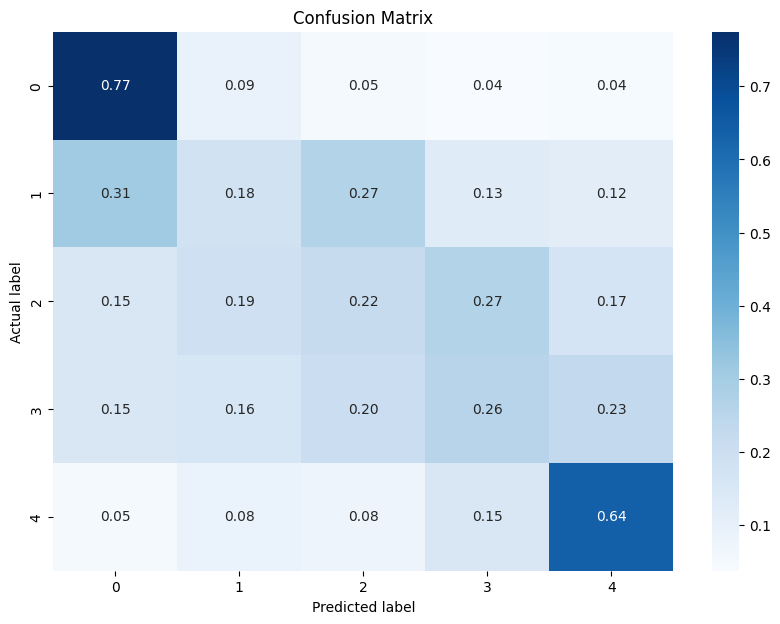

In [20]:
# 忽略警告用的
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


# 導入並訓練邏輯回歸(Logistic Regression)模型
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# 預測測試集並計算準確率
y_pred_lr = lr_model.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report

accuracy_lr = accuracy_score(y_test, y_pred_lr)
classification_report_lr = classification_report(y_test, y_pred_lr)

# 輸出結果
print(accuracy_lr)
print(classification_report_lr)

# plot_confusion_matrix(y_test, y_pred_lr)

### 混淆矩陣(Confusion Matrix)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 使用模型預測測試集
y_pred = lr_model.predict(X_test)

# 生成混淆矩陣
cm = confusion_matrix(y_test, y_pred_lr)


# 轉換為比例
cm_ratio = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# 使用Seaborn畫出混淆矩陣的熱力圖
plt.figure(figsize=(10, 7))
sns.heatmap(cm_ratio, annot=True, fmt=".2f", cmap="Blues")  # fmt='.2f' 指定顯示兩位小數
plt.title("Confusion Matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()

### 交叉驗證(Cross-Validation)

In [22]:
# 忽略警告用的
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


from sklearn.model_selection import cross_val_score

# 定義模型
lr_model_cv = LogisticRegression(max_iter=1000, random_state=42)

# 進行5-fold交叉驗證
scores = cross_val_score(lr_model_cv, X_train, y_train, cv=5)

# 輸出每一輪的準確率以及平均準確率
print("每一輪的準確率:", scores)
print("平均準確率:", scores.mean())

每一輪的準確率: [0.39006024 0.41566265 0.40060241 0.42018072 0.413273  ]
平均準確率: 0.40795580512093627


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

C_values = np.logspace(-2, 6, 10)

# 定義原始參數範圍和模型（僅使用 L1 和 L2 正則化）
original_param_grid = {"C": C_values, "penalty": ["l1", "l2"]}
original_grid_search = GridSearchCV(
    LogisticRegression(
        max_iter=1000, random_state=42, solver="liblinear"
    ),  # 'liblinear' 支持 'l1' 和 'l2'
    original_param_grid,
    cv=5,
    scoring="accuracy",
)

# 執行原始網格搜索
original_grid_search.fit(X_train, y_train)
original_best_params = original_grid_search.best_params_
original_best_score = original_grid_search.best_score_

# 定義 Elastic Net 參數範圍和模型
elastic_param_grid = {
    "C": C_values,
    "l1_ratio": np.linspace(0, 1, 10),  # 從 0 到 1 均勻分布的 5 個點
}
elastic_grid_search = GridSearchCV(
    LogisticRegression(
        max_iter=1000, random_state=42, penalty="elasticnet", solver="saga"
    ),
    elastic_param_grid,
    cv=5,
    scoring="accuracy",
)

# 執行 Elastic Net 網格搜索
elastic_grid_search.fit(X_train, y_train)
elastic_best_params = elastic_grid_search.best_params_
elastic_best_score = elastic_grid_search.best_score_

# 比較結果並顯示
print("原始最佳參數:", original_best_params)
print("原始最高準確率:", original_best_score)
print("Elastic Net 最佳參數:", elastic_best_params)
print("Elastic Net 最高準確率:", elastic_best_score)

# 判斷哪一個模型更好
if original_best_score > elastic_best_score:
    print("原始模型較好。")
else:
    print("Elastic Net 模型較好。")

原始最佳參數: {'C': 0.5994842503189409, 'penalty': 'l1'}
原始最高準確率: 0.4112686038270731
Elastic Net 最佳參數: {'C': 0.0774263682681127, 'l1_ratio': 0.0}
Elastic Net 最高準確率: 0.4010249141361827
原始模型較好。


In [24]:
import matplotlib.pyplot as plt

# 解決字體問題
plt.rcParams["font.family"] = ["Microsoft YaHei"]
plt.rcParams["axes.unicode_minus"] = False

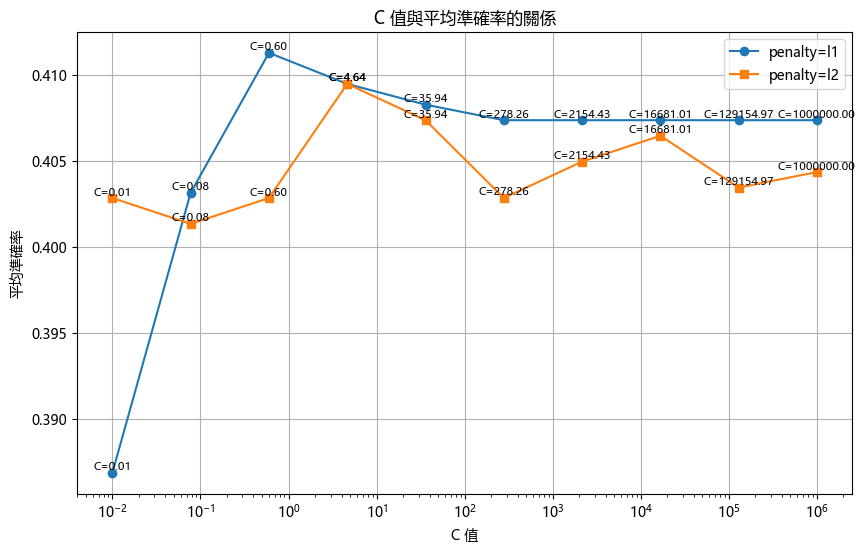

In [25]:
# 獲取參數組合和對應的準確率
params = original_grid_search.cv_results_["params"]
mean_scores = original_grid_search.cv_results_["mean_test_score"]

# 繪製原始模型的準確率與 C 值的關係圖表
plt.figure(figsize=(10, 6))
for penalty, marker in zip(["l1", "l2"], ["o", "s"]):
    penalty_mask = [param["penalty"] == penalty for param in params]
    plt.plot(
        C_values, mean_scores[penalty_mask], marker=marker, label=f"penalty={penalty}"
    )

    # 標記每個參數組合
    for i, c in enumerate(C_values):
        plt.text(
            c,
            mean_scores[penalty_mask][i],
            f"C={c:.2f}",
            fontsize=8,
            ha="center",
            va="bottom",
        )

plt.xscale("log")
plt.xlabel("C 值")
plt.ylabel("平均準確率")
plt.title("C 值與平均準確率的關係")
plt.legend()
plt.grid(True)
plt.show()

### 使用最好的C

準確率: 0.4223471539002108
分類報告:
               precision    recall  f1-score   support

           0       0.55      0.77      0.64       293
           1       0.23      0.15      0.18       281
           2       0.30      0.28      0.29       275
           3       0.30      0.22      0.25       276
           4       0.53      0.66      0.59       298

    accuracy                           0.42      1423
   macro avg       0.38      0.42      0.39      1423
weighted avg       0.38      0.42      0.40      1423



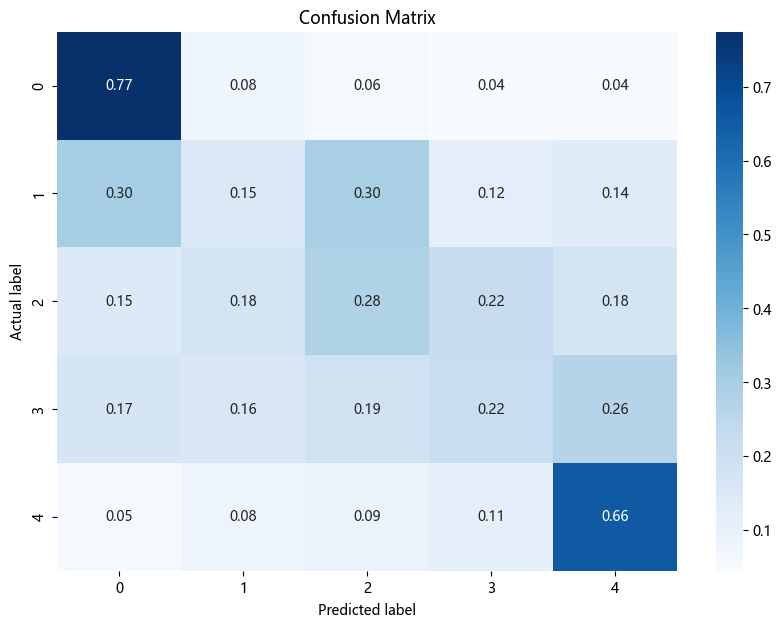

每一輪的準確率: [0.39307229 0.42620482 0.39608434 0.40813253 0.413273  ]
平均準確率: 0.40735339548238203


['lr_model_best.joblib']

In [26]:
"""使用最好的C"""

# 導入並訓練邏輯回歸(Logistic Regression)模型
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# 使用原始模型的最佳參數來設定模型
lr_model_best = LogisticRegression(
    C=278.2559402207126,
    penalty="l1",
    solver="liblinear",
    max_iter=1000,
    random_state=42,
)
lr_model_best.fit(X_train, y_train)

# 預測測試集並計算準確率
y_pred_best_lr = lr_model_best.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report

accuracy_lr = accuracy_score(y_test, y_pred_best_lr)
classification_report_lr = classification_report(y_test, y_pred_best_lr)

# 輸出結果
print("準確率:", accuracy_lr)
print("分類報告:\n", classification_report_lr)

"""建立混淆矩陣"""

plot_confusion_matrix(y_test, y_pred_best_lr)


"""交叉驗證(Cross-Validation)"""
# 進行5-fold交叉驗證
scores = cross_val_score(lr_model_best, X_train, y_train, cv=5)

# 輸出每一輪的準確率以及平均準確率
print("每一輪的準確率:", scores)
print("平均準確率:", scores.mean())

"""輸出模型"""
from joblib import dump, load

# 保存模型
dump(lr_model_best, "lr_model_best.joblib")

### 模型係數(Coefficients)

                     Feature  Coefficient
7       movie_theater_counts     0.296894
8            hospital_counts     0.092726
12                       age     0.059675
2             youbike_counts     0.016555
5   sports_facilities_counts     0.013994
3                 bus_counts     0.008782
9       salary_income_median    -0.004759
1               drink_counts    -0.010261
4                park_counts    -0.045191
0              school_counts    -0.060108
10              weekend_open    -0.453866
6                 mrt_counts    -0.605114
11           road_area_ratio   -14.966155


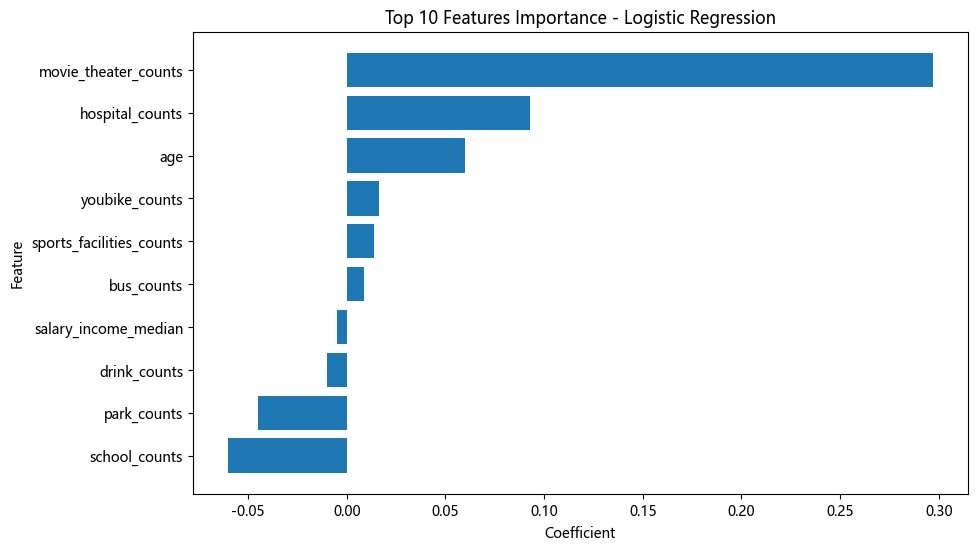

In [27]:
# 查看模型係數
import pandas as pd

feature_names = X_train.columns
coefficients = lr_model_best.coef_[0]
feature_importance = pd.DataFrame(
    {"Feature": feature_names, "Coefficient": coefficients}
)
feature_importance = feature_importance.sort_values(by="Coefficient", ascending=False)
print(feature_importance)

# 確保DataFrame已經根據Coefficient進行降序排序
feature_importance_sorted = feature_importance.sort_values(
    by="Coefficient", ascending=False
)

# 繪製特徵重要性的水平條形圖，重要性較高的特徵會顯示在最上面
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_sorted["Feature"][:10],
    feature_importance_sorted["Coefficient"][:10],
)
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Top 10 Features Importance - Logistic Regression")
plt.gca().invert_yaxis()  # 確保重要性較高的特徵顯示在最上面
plt.show()

## SVM

0.38510189739985945
              precision    recall  f1-score   support

           0       0.54      0.68      0.60       293
           1       0.12      0.00      0.01       281
           2       0.26      0.41      0.32       275
           3       0.26      0.20      0.23       276
           4       0.45      0.61      0.52       298

    accuracy                           0.39      1423
   macro avg       0.33      0.38      0.33      1423
weighted avg       0.33      0.39      0.34      1423



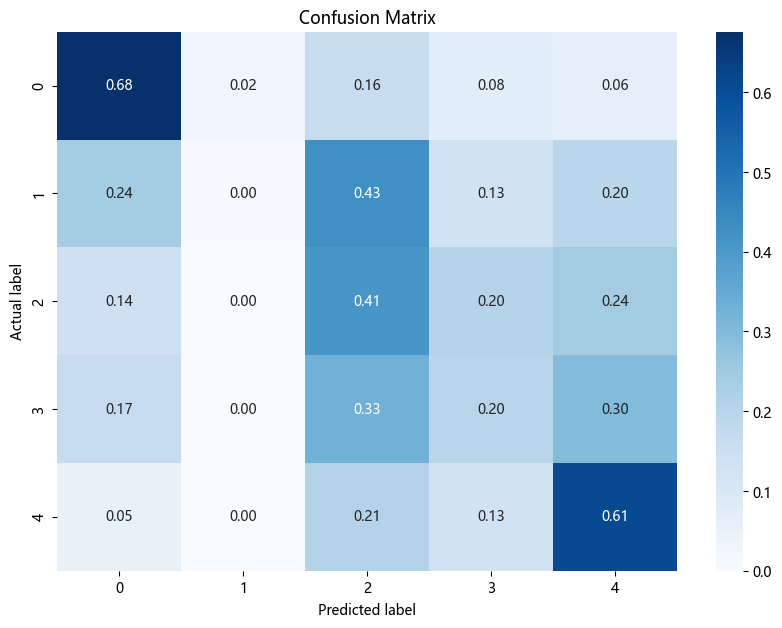

In [90]:
from sklearn.svm import SVC

# 訓練支持向量機模型，默認 高斯核（RBF核）
# svm_model = SVC(kernel='rbf', random_state=42)
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# 預測測試集
y_pred_svm = svm_model.predict(X_test)

# 計算準確率和顯示分類報告
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_report_svm = classification_report(y_test, y_pred_svm)

print(accuracy_svm)
print(classification_report_svm)

plot_confusion_matrix(y_test, y_pred_svm)

### 交叉驗證(Cross-Validation)

In [73]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# 初始化支持向量機模型
svm_model = SVC(random_state=42)

# 進行交叉驗證，這裡假設使用5折交叉驗證
scores = cross_val_score(svm_model, X_train, y_train, cv=5)

# 打印出每一折的準確率以及平均準確率
print("每一折的準確率: ", scores)
print("交叉驗證結果：平均準確率", scores.mean())

每一折的準確率:  [0.37198795 0.38855422 0.40210843 0.37801205 0.39064857]
交叉驗證結果：平均準確率 0.386262243544313


### 參數調整(Parameter Tuning)

In [91]:
import warnings
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import expon, reciprocal
import numpy as np
import matplotlib.pyplot as plt

# 忽略警告
warnings.filterwarnings("ignore", category=UserWarning)

grid_C_values = [0.1, 1, 10, 100]
dist_C_values = reciprocal(0.1, 100)

# 設定參數範圍和分佈
param_grid = {"C": grid_C_values, "gamma": [1, 0.1, 0.01, 0.001]}
param_dist = {"C": dist_C_values, "gamma": expon(scale=1.0)}

# 創建 GridSearchCV 和 RandomizedSearchCV 物件
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=0)
random_search = RandomizedSearchCV(
    SVC(), param_distributions=param_dist, n_iter=100, refit=True, verbose=0
)

# 執行擬合
grid_search.fit(X_train, y_train)
random_search.fit(X_train, y_train)

# 整理出圖的數據
results_grid = grid_search.cv_results_
results_random = random_search.cv_results_

In [93]:
# 顯示最佳參數和最佳準確率
best_grid_params = grid_search.best_params_
best_random_params = random_search.best_params_
best_grid_score = grid_search.best_score_
best_random_score = random_search.best_score_


# 比較準確率並指出哪個更高，然後創建相應的 SVC 實例
if best_grid_score > best_random_score:
    print("最佳參數 (Grid Search CV): ", best_grid_params)
    print("最佳準確率 (Grid Search CV): ", best_grid_score)
    # 直接使用具體的參數值來創建 SVC 實例
    svc_best = SVC(C=best_grid_params["C"], gamma=best_grid_params["gamma"])
elif best_grid_score < best_random_score:
    print("最佳參數 (Randomized Search CV): ", best_random_params)
    print("最佳準確率 (Randomized Search CV): ", best_random_score)
    # 直接使用具體的參數值來創建 SVC 實例
    svc_best = SVC(C=best_random_params["C"], gamma=best_random_params["gamma"])
else:
    print("兩種搜索方法提供了相同的準確率。")
    # 可以選擇任何一組參數來創建 SVC 實例，這裡選擇了 Grid Search 的參數
    svc_best = SVC(C=best_grid_params["C"], gamma=best_grid_params["gamma"])

"""交叉驗證"""

from sklearn.model_selection import cross_val_score

# 進行交叉驗證
cross_val_scores_best = cross_val_score(svc_best, X_train, y_train, cv=5)


# 使用最佳參數和全部訓練數據來訓練 SVC
svc_best.fit(X_train, y_train)

# 現在 svc_best 是被訓練過的，可以計算交叉驗證分數
cross_val_scores_best = cross_val_score(svc_best, X_train, y_train, cv=5)

# 計算平均交叉驗證準確率
avg_score_best = np.mean(cross_val_scores_best)
print("平均交叉驗證準確率: ", avg_score_best)

# 保存被訓練過的模型
dump(svc_best, "svc_best.joblib")


"""輸出模型"""
from joblib import dump

# 保存模型
dump(svc_best, "svc_best.joblib")

最佳參數 (Grid Search CV):  {'C': 1, 'gamma': 0.001}
最佳準確率 (Grid Search CV):  0.397410001998946
平均交叉驗證準確率:  0.397410001998946


['svc_best.joblib']

### XGboost

In [ ]:
pip install xgboost -q


In [58]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

le = LabelEncoder()
y_train = le.fit_transform(y_train)

# 建立XGBoost模型
model = xgb.XGBClassifier(
    enable_categorical=True,
)

# 訓練模型
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [59]:
y_pred = model.predict(X_test)  # 或 X_train，取決於您想要評估的數據集

# accuracy = (TP + TN) / (TP + TN + FP + FN)

# precision = TP / (TP + FP)

# recall = TP / (TP + FN)
y_pred
# 假設 y_pred 是您已經有的預測結果
average_of_y_pred = sum(y_pred) / len(y_pred)
average_of_y_pred

2.106113843991567

In [60]:
y_pred = model.predict(X_test)


from sklearn.metrics import (
    precision_score,
    recall_score,
    confusion_matrix,
    accuracy_score,
)

# 計算準確率(Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"準確率: {accuracy}")  # 印出準確率

# 計算精確率(Precision)
precision = precision_score(
    y_test, y_pred, average="weighted"
)  # 使用 'weighted' 方法來處理類別不平衡的情況
print(f"精確率: {precision}")  # 印出精確率

# 計算召回率(Recall)
recall = recall_score(
    y_test, y_pred, average="weighted"
)  # 使用 'weighted' 方法來處理類別不平衡的情況
print(f"召回率: {recall}")  # 印出召回率

準確率: 0.4258608573436402
精確率: 0.42555799310359976
召回率: 0.4258608573436402


In [ ]:
"""不能用自己的"""

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 訓練 XGBoost 模型
xgb_model = xgb.XGBClassifier(
    enable_categorical=True,
)
xgb_model.fit(X_train, y_train)

# 進行預測
y_pred_xgb_transformed = xgb_model.predict(X_test)

# 計算準確率和其他性能指標
accuracy_xgb = accuracy_score(y_test, y_pred_xgb_transformed)
classification_report_xgb = classification_report(y_test, y_pred_xgb_transformed)

# 將預測結果轉換回原始範圍（1~5）
y_pred_xgb_original = y_pred_xgb_transformed + 1

# 輸出結果
print(f"Accuracy: {accuracy_xgb}")
print("Classification Report:\n", classification_report_xgb)

# 如果您需要使用預測結果進行其他操作，請使用 y_pred_xgb_original

# 計算混淆矩陣
cm = confusion_matrix(y_test, y_pred_xgb_transformed)

# 轉換為比例
cm_ratio = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# 使用Seaborn畫出混淆矩陣的熱力圖
plt.figure(figsize=(10, 7))
sns.heatmap(cm_ratio, annot=True, fmt=".2f", cmap="Blues")  # fmt='.2f' 指定顯示兩位小數
plt.title("Confusion Matrix (混淆矩陣)")
plt.ylabel("Actual label (實際標籤)")
plt.xlabel("Predicted label (預測標籤)")
plt.show()

### 交叉驗證(Cross-Validation)

In [51]:
# y_transformed = y.iloc[:, 0].astype("int") - 1

In [61]:
from sklearn.model_selection import cross_val_score

# 定義 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=5, random_state=42)

# 執行交叉驗證
# cv 參數決定折數，例如，cv=5 代表 5 折交叉驗證
# scoring 參數可以根據需要更改，例如使用 'accuracy' 來獲取準確率
scores = cross_val_score(xgb_model, X, y, cv=5, scoring="accuracy")

# 輸出結果
print("每一輪的準確率:", scores)
print("平均準確率:", scores.mean())
# print('Standard deviation of accuracy:', scores.std())

每一輪的準確率: [0.32771338 0.43624868 0.38185654 0.29113924 0.28375527]
平均準確率: 0.3441426240368498


### 參數調整(Parameter Tuning)

In [63]:
from sklearn.model_selection import GridSearchCV


# 定義超參數網格
param_grid = {
    "max_depth": [3, 4, 5],  # 最大深度
    "learning_rate": [0.1, 0.01, 0.001],  # 學習率
    "n_estimators": [100, 200, 300],  # 樹的數量
    "objective": ["multi:softmax", "multi:softprob"],  # 目標函數
    "subsample": [0.6, 0.8, 1],  # 子樣本比例
    "colsample_bytree": [0.8, 1, 1.2],  # 每棵樹隨機選擇特徵的比例
}

# 初始化XGBoost分類器
xgb_classifier = xgb.XGBClassifier(random_state=42, num_class=5)

# 設置GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=-1,
    cv=3,
    verbose=2,
)

# 擬合GridSearchCV
grid_search.fit(X_train, y_train)

# 輸出最佳參數
print("找到的最佳參數: ", grid_search.best_params_)

# 輸出最佳準確率
print("找到的最佳準確率: ", grid_search.best_score_)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
486 fits failed out of a total of 1458.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
486 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\student\AppData\Local\Programs\Python\Python312\Lib

找到的最佳參數:  {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'objective': 'multi:softmax', 'subsample': 0.6}
找到的最佳準確率:  0.4522505421959986


### 用最好的參數做

最佳模型準確率: 0.46872803935347856
最佳模型分類報告:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77       293
           1       0.31      0.17      0.22       281
           2       0.31      0.39      0.34       275
           3       0.33      0.29      0.31       276
           4       0.53      0.70      0.60       298

    accuracy                           0.47      1423
   macro avg       0.45      0.46      0.45      1423
weighted avg       0.46      0.47      0.46      1423



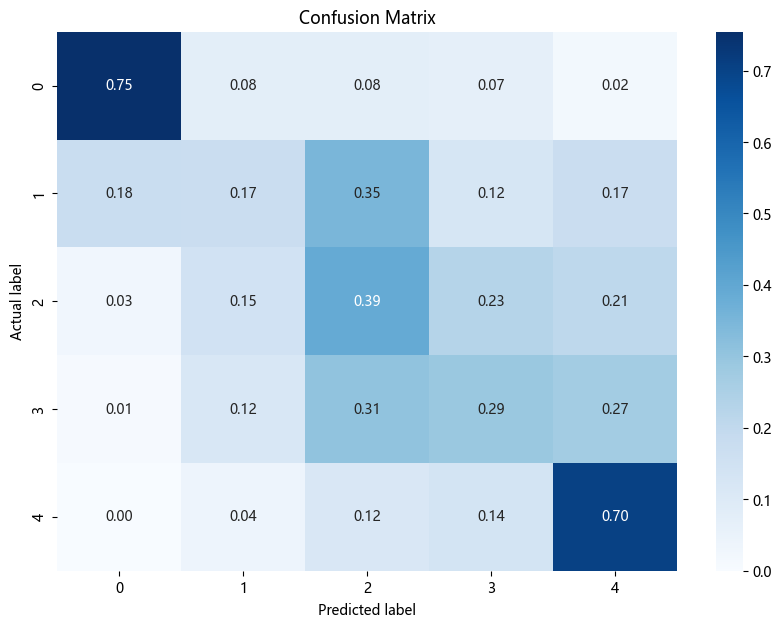

['XGBoost model_best.joblib']

In [64]:
# 使用最佳參數對整個訓練集進行重新訓練
best_xgb_model = grid_search.best_estimator_

# 進行預測
y_pred_best_XG = best_xgb_model.predict(X_test)

# 計算準確率和其他性能指標
accuracy_best = accuracy_score(y_test, y_pred_best_XG)
classification_report_best = classification_report(y_test, y_pred_best_XG)

# 輸出結果
print(f"最佳模型準確率: {accuracy_best}")
print("最佳模型分類報告:\n", classification_report_best)

plot_confusion_matrix(y_test, y_pred_best_XG)

"""輸出模型"""
from joblib import dump, load

# 保存模型
dump(best_xgb_model, "XGBoost model_best.joblib")

                     Feature  Importance
6                 mrt_counts    0.323421
11           road_area_ratio    0.178868
2             youbike_counts    0.065621
12                       age    0.065197
10              weekend_open    0.052089
9       salary_income_median    0.046791
7       movie_theater_counts    0.044062
5   sports_facilities_counts    0.040624
3                 bus_counts    0.038559
4                park_counts    0.038507
1               drink_counts    0.037660
0              school_counts    0.034491
8            hospital_counts    0.034110


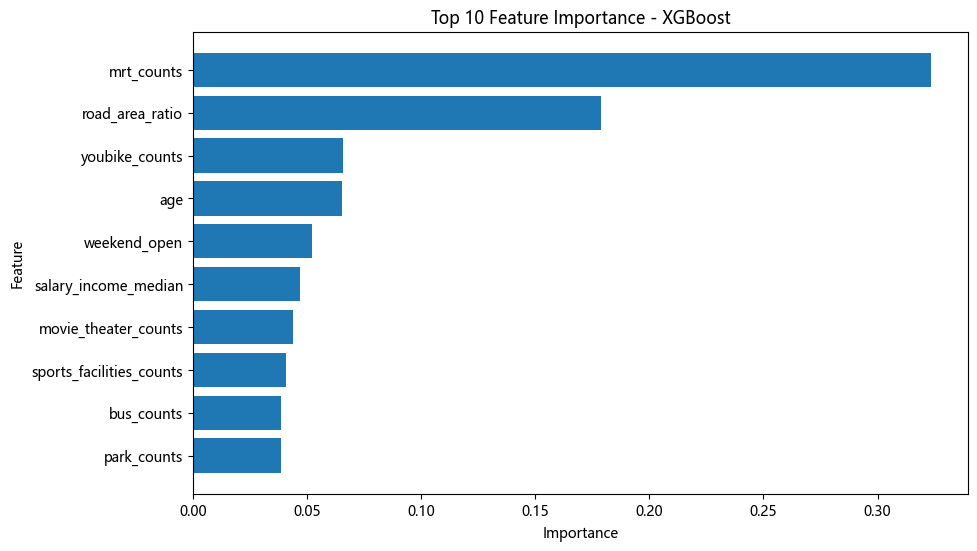

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

feature_names = X_train.columns
importances = best_xgb_model.feature_importances_
feature_importance = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# 按照重要性進行降序排列
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# 顯示排序後的DataFrame
print(feature_importance)


# 繪製特徵重要性的水平條形圖，重要性較高的特徵會顯示在最上面
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance["Feature"][:10],
    feature_importance["Importance"][:10],
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importance - XGBoost")
plt.gca().invert_yaxis()  # 確保重要性較高的特徵顯示在最上面
plt.show()

## AdaBoost

c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy (準確率): 0.43710470836261417
Classification Report (分類報告):
               precision    recall  f1-score   support

           0       0.71      0.72      0.71       293
           1       0.29      0.21      0.24       281
           2       0.31      0.37      0.33       275
           3       0.30      0.27      0.28       276
           4       0.51      0.60      0.55       298

    accuracy                           0.44      1423
   macro avg       0.42      0.43      0.42      1423
weighted avg       0.43      0.44      0.43      1423



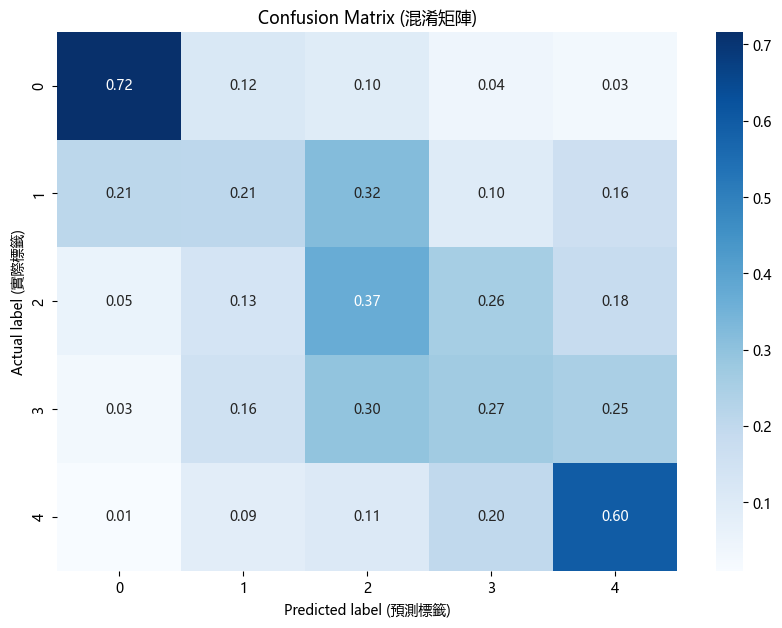

In [66]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 訓練 AdaBoost 模型
# 這裡我們設置 50 個弱學習器，並且使用決策樹作為默認的基學習器
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)

# 進行預測
y_pred_ada_transformed = ada_model.predict(X_test)

# 計算準確率和其他性能指標
accuracy_ada = accuracy_score(y_test, y_pred_ada_transformed)
classification_report_ada = classification_report(y_test, y_pred_ada_transformed)

# 將預測結果轉換回原始範圍（1~5）
y_pred_ada_original = y_pred_ada_transformed + 1

# 輸出結果
print(f"Accuracy (準確率): {accuracy_ada}")
print("Classification Report (分類報告):\n", classification_report_ada)

# 如果您需要使用預測結果進行其他操作，請使用 y_pred_ada_original

# 計算混淆矩陣
cm = confusion_matrix(y_test, y_pred_ada_transformed)

# 轉換為比例
cm_ratio = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# 使用Seaborn畫出混淆矩陣的熱力圖
plt.figure(figsize=(10, 7))
sns.heatmap(cm_ratio, annot=True, fmt=".2f", cmap="Blues")  # fmt='.2f' 指定顯示兩位小數
plt.title("Confusion Matrix (混淆矩陣)")
plt.ylabel("Actual label (實際標籤)")
plt.xlabel("Predicted label (預測標籤)")
plt.show()

### 交叉驗證(Cross-Validation)

In [67]:
from sklearn.model_selection import cross_val_score

# 定義 AdaBoost 分類器
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)

# 進行交叉驗證，cv 參數指定交叉驗證的折數
# 如果資料集較小，您可以考慮使用較大的折數，例如 cv=10
# 請確保 X 和 y 是您的特徵和標籤資料
# 這個過程可能會花費一些時間，特別是當資料集很大時
cv_scores = cross_val_score(ada_model, X, y, cv=5)

# 輸出交叉驗證結果
print("交叉驗證準確率:", cv_scores)
print("平均交叉驗證準確率:", np.mean(cv_scores))

c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the defa

交叉驗證準確率: [0.33719705 0.37302424 0.33860759 0.31118143 0.31540084]
平均交叉驗證準確率: 0.3350822317962946


c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### 參數調整(Parameter Tuning)

In [68]:
# 忽略警告用的
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# 定義參數範圍
param_grid_ada = {
    "n_estimators": [10, 50, 100, 200],
    "learning_rate": [0.01, 0.1, 1, 10],
}
param_dist_ada = {"n_estimators": randint(50, 500), "learning_rate": [0.01, 0.1, 1, 10]}

# 創建 GridSearchCV 和 RandomizedSearchCV 物件
grid_search_ada = GridSearchCV(
    AdaBoostClassifier(random_state=42), param_grid_ada, refit=True, verbose=0
)
random_search_ada = RandomizedSearchCV(
    AdaBoostClassifier(random_state=42),
    param_distributions=param_dist_ada,
    n_iter=100,
    refit=True,
    verbose=0,
)

# 執行擬合
grid_search_ada.fit(X_train, y_train)
random_search_ada.fit(X_train, y_train)

# 選擇最佳模型
best_model_grid_ada = grid_search_ada.best_estimator_
best_model_random_ada = random_search_ada.best_estimator_

# 打印最佳參數
print(
    "Best parameters (GridSearchCV) (最佳參數-網格搜索):", grid_search_ada.best_params_
)
print(
    "Best parameters (RandomizedSearchCV) (最佳參數-隨機搜索):",
    random_search_ada.best_params_,
)

# 使用最佳模型進行預測
y_pred_ada_best_grid = best_model_grid_ada.predict(X_test)
y_pred_ada_best_random = best_model_random_ada.predict(X_test)

# 您可以基於 y_pred_ada_best_grid 和 y_pred_ada_best_random 進行進一步的分析和評估

# 計算準確率
accuracy_ada_best_grid = accuracy_score(y_test, y_pred_ada_best_grid)
accuracy_ada_best_random = accuracy_score(y_test, y_pred_ada_best_random)

# 打印準確率
print("Accuracy (GridSearchCV) (準確率-網格搜索):", accuracy_ada_best_grid)
print("Accuracy (RandomizedSearchCV) (準確率-隨機搜索):", accuracy_ada_best_random)

# 比較準確率並選擇最好的模型
if accuracy_ada_best_grid > accuracy_ada_best_random:
    AdaBoost_model_best = best_model_grid_ada
    print("GridSearchCV 的模型表現較好。")
else:
    AdaBoost_model_best = best_model_random_ada
    print("RandomizedSearchCV 的模型表現較好。")

# 使用最佳模型進行其他操作
# 例如，您可以使用 best_model 進行更多預測或進行深入分析

c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the defa

Best parameters (GridSearchCV) (最佳參數-網格搜索): {'learning_rate': 0.1, 'n_estimators': 50}
Best parameters (RandomizedSearchCV) (最佳參數-隨機搜索): {'learning_rate': 0.01, 'n_estimators': 474}
Accuracy (GridSearchCV) (準確率-網格搜索): 0.4342937456078707
Accuracy (RandomizedSearchCV) (準確率-隨機搜索): 0.43851018973998596
RandomizedSearchCV 的模型表現較好。


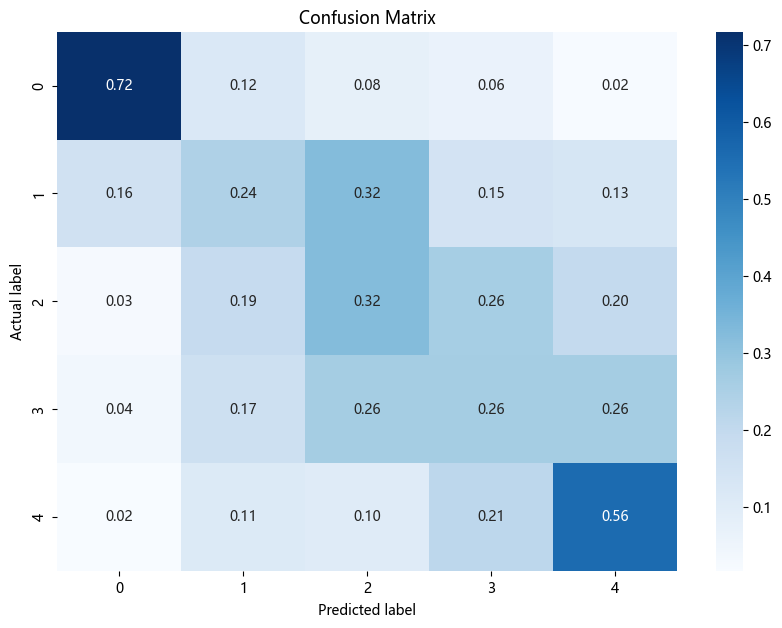

c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the defa

Cross Validation Scores: [0.32982086 0.44783983 0.4335443  0.41877637 0.31962025]
平均準確率: 0.3899203247477913


c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the defa

['AdaBoost_model_best.joblib']

In [69]:
# 忽略警告用的
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

plot_confusion_matrix(y_test, y_pred)

from sklearn.model_selection import cross_val_score

# 使用交叉驗證評估模型
cross_val_scores = cross_val_score(AdaBoost_model_best, X, y, cv=5)  # 使用5折交叉驗證

# 打印每次交叉驗證的準確度
print("Cross Validation Scores:", cross_val_scores)
# 打印平均交叉驗證準確度
print("平均準確率:", cross_val_scores.mean())

scores = cross_val_score(AdaBoost_model_best, X_train, y_train, cv=5)

"""輸出模型"""
from joblib import dump, load

# 保存模型
dump(AdaBoost_model_best, "AdaBoost_model_best.joblib")

                     Feature  Importance
11           road_area_ratio    0.236287
10              weekend_open    0.179325
2             youbike_counts    0.168776
6                 mrt_counts    0.109705
9       salary_income_median    0.099156
3                 bus_counts    0.097046
1               drink_counts    0.067511
5   sports_facilities_counts    0.029536
12                       age    0.012658
0              school_counts    0.000000
4                park_counts    0.000000
7       movie_theater_counts    0.000000
8            hospital_counts    0.000000


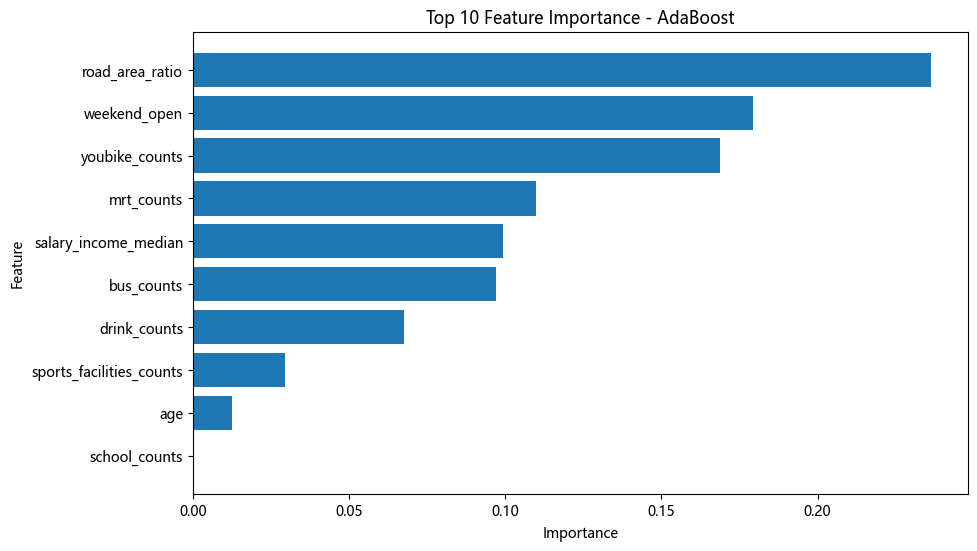

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 AdaBoost_model_best 是您的训练好的模型
feature_names = X_train.columns  # X_train 是训练数据集
importances = AdaBoost_model_best.feature_importances_  # 获取特征重要性
feature_importance = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# 按照重要性进行降序排列
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# 显示排序后的DataFrame
print(feature_importance)

# 绘制特征重要性的水平条形图，重要性较高的特征会显示在最上面
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance["Feature"][:10],  # 只显示前10个特征
    feature_importance["Importance"][:10],
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importance - AdaBoost")
plt.gca().invert_yaxis()  # 确保重要性较高的特征显示在最上面
plt.show()

# 集成式學習

## 載入模型

Boosting

Bagging

https://chat.openai.com/c/5148fbf7-f239-4393-876b-aa680d7293c5